In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

# Exploratory Climate Analysis

In [11]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [21]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
LatestDate=np.ravel(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
LatestDate=str(LatestDate).replace("-","").replace("'","").replace("[","").replace("]","")
LatestDate

'20170823'

In [155]:
#Date Calculation Using regex
import re
#Split Year, Month and Date to form a Date time format
CYear=int(re.sub(r'(\d{4})(\d{2})(\d{2})', r'\1', LatestDate))
CMonth=int(re.sub(r'(\d{4})(\d{2})(\d{2})', r'\2', LatestDate))
CDay=int(re.sub(r'(\d{4})(\d{2})(\d{2})', r'\3', LatestDate))
LatestDateFormat = dt.datetime(CYear,CMonth,CDay)
#Subract a year
from dateutil.relativedelta import relativedelta
OneYearAgoDate =(LatestDateFormat) + relativedelta(years=-1)
# Convert Back to queriable pattern
Latest = re.sub(r'(\d{4})(\d{2})(\d{2})', r'\1-\2-\3', LatestDate)
OYear=str(OneYearAgoDate.year)
OMonth=str(OneYearAgoDate.month)
ODay=str(OneYearAgoDate.day)
if len(OMonth) == 1:
    OMonth= "0" + OMonth
if len(ODay) == 1:
    ODay= "0" + ODay
OneYearAgo = OYear + "-" + OMonth + "-" + ODay
Latest,OneYearAgo

('2017-08-23', '2016-08-23')

In [105]:
# Perform a query to retrieve the data and precipitation scores
LastYearPreciptitationData=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= OneYearAgo).order_by(Measurement.date.desc()).all()

In [106]:
session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= OneYearAgo).order_by(Measurement.date.desc()).count()

2230

In [108]:
# Save the query results as a Pandas DataFrame and set the index to the date column
LPData=pd.DataFrame()
for L in LastYearPreciptitationData:
        df=pd.DataFrame({'Date':[L[0]],"Prcp":[L[1]]})
        LPData=LPData.append(df)
# Sort the dataframe by date
LPData=LPData.set_index('Date').sort_values(by="Date",ascending=False)
LPData.head(10)

,Prcp
Date,
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-23,0.00
2017-08-22,0.00
2017-08-22,0.00
2017-08-22,0.50
2017-08-21,0.00
2017-08-21,0.02


![precipitation](Images/precipitation.png)

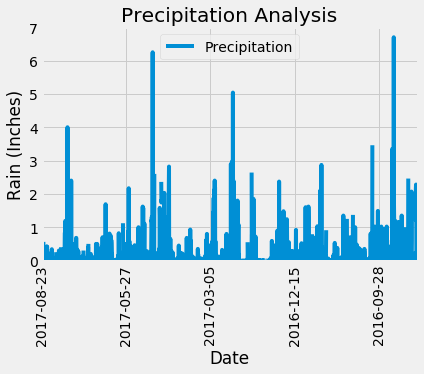

In [109]:
# Use Pandas Plotting with Matplotlib to plot the data
LPData.plot(rot=90);
plt.ylim(0,7)
plt.xlabel("Date")
plt.ylabel("Rain (Inches)")
plt.title("Precipitation Analysis")
plt.legend(["Precipitation"])
plt.savefig("./Output/Figure1.png")
plt.show()

In [111]:
# Use Pandas to calcualte the summary statistics for the precipitation data
LPData.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [114]:
# Design a query to show how many stations are available in this dataset?
# ---- From Measurement Data
session.query(Measurement.station).group_by(Measurement.station).count()
#----From Station Date
session.query(Station).count()

9

In [117]:
#-- Method 1 -- Using DataFrame
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Stations=session.query(Measurement.station,Measurement.tobs).all()
station_df=pd.DataFrame()
for s in Stations:
    df=pd.DataFrame({"Station":[s.station],"Tobs":[s.tobs]})
    station_df=station_df.append(df)
ActiveStation=station_df.Station.value_counts()
ActiveStation

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: Station, dtype: int64

In [126]:
#-- Method 2 -- Using Direct Query
ActiveStationList=session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
ActiveStationList

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [116]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_df[station_df.Station == 'USC00519281'].Tobs.min(),station_df[station_df.Station == 'USC00519281'].Tobs.max(),station_df[station_df.Station == 'USC00519281'].Tobs.mean()

(54.0, 85.0, 71.66378066378067)

In [129]:
# Choose the station with the highest number of temperature observations.
print(f"The Station with Highest Number of temperature obervations is {ActiveStationList[0][0]} and the No of Observations are {ActiveStationList[0][1]}")

The Station with Highest Number of temperature obervations is USC00519281 and the No of Observations are 2772


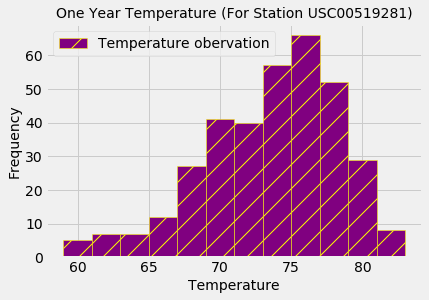

In [138]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Last12TempO=session.query(Measurement.tobs).filter(Measurement.date > OneYearAgo).filter(Measurement.station==ActiveStationList[0][0]).all()
df=pd.DataFrame(Last12TempO)
plt.hist(df['tobs'],12,color='purple',hatch="/",edgecolor="yellow")
plt.xlabel("Temperature",fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("One Year Temperature (For Station USC00519281)",fontsize=14)
labels=["Temperature obervation"]
plt.legend(labels)
plt.savefig("./Output/Figure2.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [139]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [141]:
#----First Sample
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
TemperatureAverageLast12Months=calc_temps(OneYearAgo, Latest)
print(TemperatureAverageLast12Months)

[(58.0, 74.59058295964125, 87.0)]


In [142]:
#----Second Sample
calc_temps('2015-08-21', '2016-08-21')

[(56.0, 74.45888368129528, 86.0)]

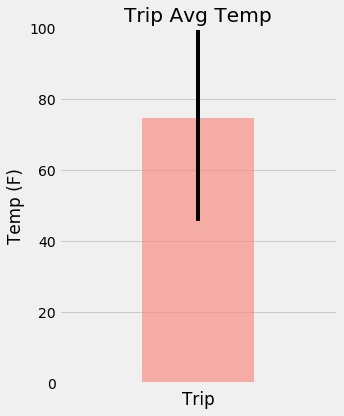

In [149]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
Error = TemperatureAverageLast12Months[0][2]-TemperatureAverageLast12Months[0][0]
AverageTemp = TemperatureAverageLast12Months[0][1]
MinTemp = TemperatureAverageLast12Months[0][0]
MaxTemp = TemperatureAverageLast12Months[0][2]

fig, ax = plt.subplots(figsize=(5,6))
bar_chart = ax.bar(1 , AverageTemp, color= 'salmon', tick_label='',yerr=Error, alpha=0.6)
ax.set_xlabel("Trip")
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        
#label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
ax.xaxis.grid()
fig.tight_layout()
plt.savefig("./Output/Figure3.png")
plt.show()

<IPython.core.display.Javascript object>


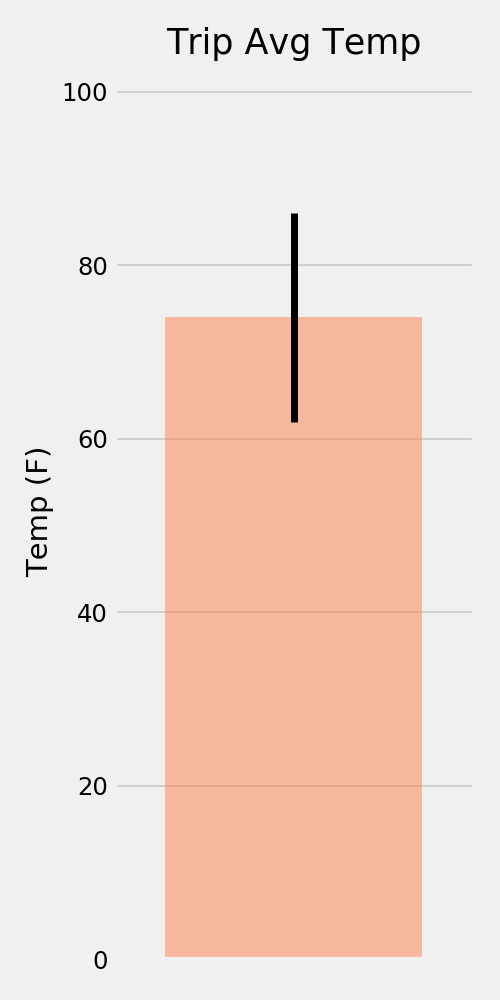

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [150]:
TripStartTime= '2016-08-21'
TripEndTime = '2016-08-30'

FirstStep = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
PlaceForTrip = session.query(*FirstStep).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= TripStartTime).\
    filter(Measurement.date <= TripEndTime).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print (PlaceForTrip)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 7.560000000000001), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 7.479999999999999), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.16), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.55), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.4), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.69), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)]


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [151]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [170]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
TripStartTime= '2016-08-21'
TripEndTime = '2016-08-30'
# Stip off the year and save a list of %m-%d strings
TripStartTime=TripStartTime.replace("-","")
StartDate=int(re.sub(r'(\d{4})(\d{2})(\d{2})', r'\3', TripStartTime))
TripEndTime=TripEndTime.replace("-","")
EndDate=int(re.sub(r'(\d{4})(\d{2})(\d{2})', r'\3', TripEndTime))
TripMonth=re.sub(r'(\d{4})(\d{2})(\d{2})', r'\2', TripEndTime)
if len(TripMonth) == 1:
    TripMonth= "0" + TripMonth
# Use the start and end date to create a range of dates
Dates = [f"{TripMonth}-{num}" for num in range(StartDate, EndDate)]

# Loop through the list of %m-%d strings and calculate the normals for each date
for d in Dates:
    Normal = daily_normals(d)
    normals.extend(Normal)
    
normals

[(67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0)]

In [175]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
TempMin = [x[0] for x in normals]
TempAvg = [x[1] for x in normals]
TempMax = [x[2] for x in normals]
SYear=int(re.sub(r'(\d{4})(\d{2})(\d{2})', r'\1', TripStartTime))
TripDatesYear = [f"{SYear}-{d}" for d in Dates]
TripDatesYear

trip_normals = pd.DataFrame({"TempMin":TempMin, "TempAvg":TempAvg, "TempMax":TempMax, "date":TripDatesYear}).set_index("date")
trip_normals.head()

,TempMin,TempAvg,TempMax
date,,,
2016-08-21,67.0,76.400000,83.0
2016-08-22,69.0,76.471698,84.0
2016-08-23,67.0,76.692308,87.0
2016-08-24,70.0,75.961538,84.0
2016-08-25,69.0,76.960784,82.0


KeyError: 'date'

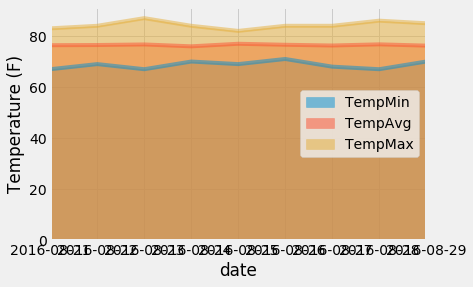

In [176]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals.plot(kind="area", stacked=False)
plt.legend(loc="right")
plt.ylabel("Temperature (F)")
plt.xticks(range(len(trip_normals["date"])), trip_normals["date"], rotation="60")
plt.show()

In [177]:
# Plot the daily normals as an area plot with `stacked=False`
